# Курсовой проект

### Задание для курсового проекта

Real Estate Price Prediction
Geekbrains Python for Data Science course competition

Задача - предсказать цены на квартиры в датасете test.csv. 
Даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

#### Подключаем необходимые библиотеки и задаем переменные окружения

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

#### Создаем функцию оценки модели 

Функцию взял как есть из Урока 10

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Создадим функцию приведения типов

Так как необходимо вполнить приведение типов для тренировочного, валидационного и тестового наборов данных создал отдельную функцию

In [5]:
def types_reset(X):
    # Изменяем тип данных для столбцов Id и DistrictId в тип обьект так как 
    # данные типы не являються по факту вещественными.
    X['Id'] = X['Id'].astype(str)
    X['DistrictId'] = X['DistrictId'].astype(str)
    # Так же выполнил преведение типа HouseFloor к типу int64 (по умолчанию float64). 
    # Если данное привединие типа не выполнить могут возникнуть ошибки 
    # в процессе работы функции transform класса DataPreprocessing
    X['HouseFloor'] = X['HouseFloor'].astype('int64')

#### Создаем клас предобработки данных

Взял клас как есть из Урока 10, но добавил обучение и обработку признака Ecology_1.

В подходе к обработке данного признака исходил из следующих предпосылок:

1. Показатель признака варьируеться от 0 до 1 что являеться мапингом какогото процентного показателя экологичности, принципа расчета которго нам не известны.
2. Можно сделать предположение что данный показатель отражет степень экологичности того или иного района и соответственно можно сделать вывод что данный показатель навряд ли может быть равен 0 или 1 так как в городе нет районов с идеальной экологией и экологией с невозможностью жизни человека.
3. Так как максимальные показатели со значением 1 или близким к нему нет, а вот значений равным 0 очень много, то на мой взгляд необходимо их обработать.

Соответственно в обработке показателей использовал следующую логику:
Создал словарь где ключем являеться номер района а значением может быть один из следующих вариантов в соответствии с условиями:

    1. При наличии нескольких показателей для района с разной частотностью (модой) выбираем один наиболее частотный и присваиваем его всем показателям с 0 значением
    
    2. В случае если для района определны только 0 показатели, заменяем их на медиану для всех районов данного признака
    
    3. В случае если в районе несколько показателей с одинаковой частотностью то 0 показатели заменям на медиану от этих показателей с одинаковой модой.
    
Так же для отображеия показателей в признаке Ecology_1 имевших 0 значение создаю новый признак Ecology_1_zero. Для 0 значений в Ecology_1 присваиваю в новом признаке 1, для всех прочих 0.

2. В теле обработки соответствия этажа квартиры этажности дома изменил лямбда функцию apply(lambda x: random.randint(1,x)) на 
apply(lambda x: np.random.randint(1, high=x+1))  так как у меня такая реализауия работает более стабильно и не вызывает ошибок.

In [6]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.ecology_1_mode_by_district = None # Наиболее частотный показатель  экологии по району
        self.ecology_1_mode_by_df = None # Наиболее частотный показатель экологии по все набору данных
        
    def fit(self, X):
        """Сохранение статистик"""
        # Получение списка уникальных дистриктов
        
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
        # Расчет моды для признака Ecology_1 по всему датафрейму
        self.ecology_1_median_by_df = X['Ecology_1'].median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: np.random.randint(1, high=x+1))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        # Ecology_1
        # Расчет моды для признака Ecology_1 для каждого района и формирование словаря значений 'район': <мода>
        self.ecology_1_mode_by_district = {} # Инициализируем словарь
        
        # Расчитываем моду для каждого района и записываем ее в словарь
        for district in X['DistrictId'].unique():
            self.ecology_1_mode_by_district[district] = X.loc[(X['DistrictId'] == district) & 
                                                         (X['Ecology_1'] > 0), 'Ecology_1'].mode()
            # Если в районе несколько одинаковых по частотности значений то берем медиану от этих значений
            if len(self.ecology_1_mode_by_district[district]) > 1:
                self.ecology_1_mode_by_district[district] = pd.Series(self.ecology_1_mode_by_district[district].median())
            # Если в районе все значения признака равны 0 то берем моду для всего датафрейма
            elif len(self.ecology_1_mode_by_district[district]) == 0:
                self.ecology_1_mode_by_district[district] = pd.Series(self.ecology_1_median_by_df)
        
        # Создаем признак указывающий на нулевые значения признака Ecology_1
        X['Ecology_1_zero'] = 0
        X.loc[X['Ecology_1'] == 0, 'Ecology_1_zero'] = 1
        
        # Присваиваем 0 показателяем в признаке Ecology_1 значение из словаря в соответствии с районом
        for district in X['DistrictId'].unique():
            ecology_condition = (X['DistrictId'] == district) & (X['Ecology_1_zero'] == 1)
            X.loc[ecology_condition, 'Ecology_1'] = self.ecology_1_mode_by_district[district][0]

        
        X.fillna(self.medians, inplace=True)
        
        return X

#### Создадим клас генерации новых признаков

Данный клас взял как есть из Урока 10, единстивенное убрал генерацию двух признаков: MedPriceByDistrict и new_district,
так как первый явно ведет к переобучению модели а второй практически не используеться в моделе.

In [7]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        #self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        #if self.med_price_by_district is not None:
        #    X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        #    X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

#### Создадим функцию масштабирования признаков

Так как важность признаков очень не однородна проведем масштабирование признаков

In [8]:
def features_scaler(X, feature_names):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X, columns=feature_names)
    return X_scaled

#### Определим пути к данным

In [9]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

#### Отбор признаков

Взял как есть из Урока 10, только удалил признаки MedPriceByDistrict и new_district и добавил признак Ecology_1_zero.

In [10]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'Ecology_1_zero', 'IsDistrictLarge', 'MedPriceByFloorYear']

target_name = 'Price'

#### Загружаем датасеты

In [11]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [12]:
test_df = pd.read_csv(TEST_DATASET_PATH)

Выполняем приведение типов для тренировочного и тестового набора данных

In [13]:
types_reset(train_df)

In [14]:
types_reset(test_df)

Удаляем признак 'Price' из набора данных X и оставляем только признак 'Price' для целевого набора данных y

In [15]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

#### Разбиение на трейн и тест

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=44)

#### Обучение перед предварительной обработкой данных

In [17]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

#### Обработка и нормализация данных для тренировочного, валидационного и тестового набора данных

In [18]:
X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

#### Обучение и генерация новых признаков для тренировочного, валидационного и тестового набора данных

In [19]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 28), (3300, 28), (5000, 28))

In [20]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

#### Финальная проверка тренировочного, валидационного и тестового набора данных на пустые значения

In [21]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

#### Проведем масштабирование признаков

In [22]:
X_train_scaled = features_scaler(X_train, feature_names + new_feature_names)
X_valid_scaled = features_scaler(X_valid, feature_names + new_feature_names)
test_df_scaled = features_scaler(test_df, feature_names + new_feature_names)

### Построение модели

#### Обучение модели через алгооритм - Случайный лес

Сложная модель ниже подходит больше с точки зрения переобучения, результаты на кагл отправлял по результатам StackingRegression

In [27]:
rf_model = RandomForestRegressor(random_state=44, criterion='mse')
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=44)

#### Оценка модели

Train R2:	0.964
Test R2:	0.723


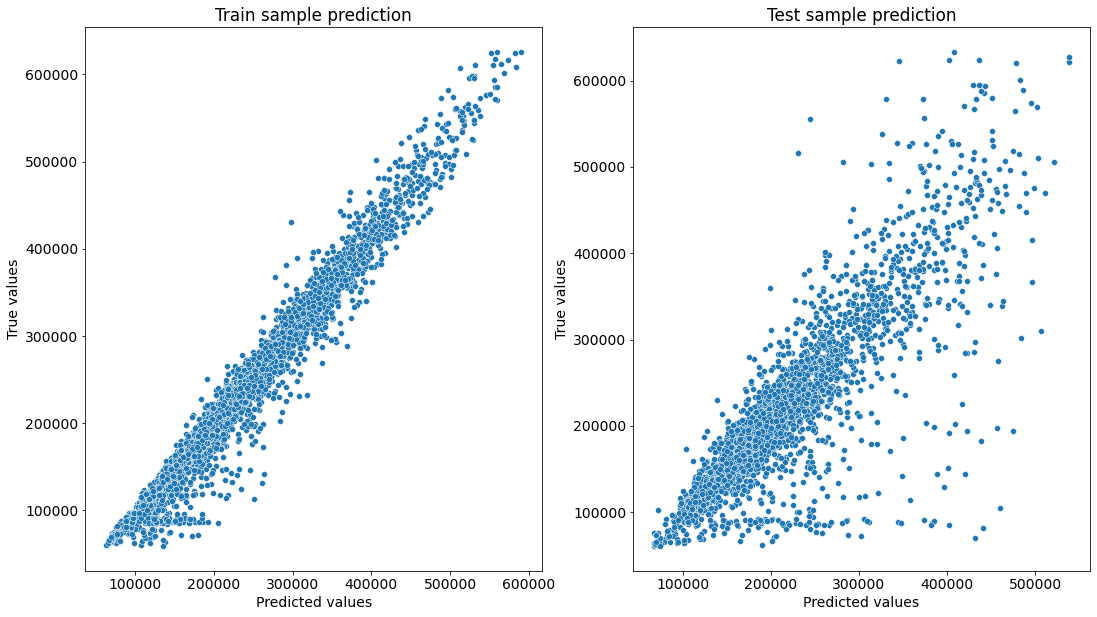

In [28]:
y_train_preds = rf_model.predict(X_train_scaled)
y_test_preds = rf_model.predict(X_valid_scaled)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кросс-валидация

In [31]:
cv_score = cross_val_score(rf_model, X_train_scaled, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=44))
cv_score

array([0.75128358, 0.71347442, 0.73125909])

In [32]:
cv_score.mean()

0.7320056952081861

#### Важность признаков

In [33]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.420660
20,DistrictSize,0.197017
12,Social_3,0.054353
0,Rooms,0.044635
2,LifeSquare,0.034350
11,Social_2,0.031174
6,HouseYear,0.028682
7,Ecology_1,0.028363
23,MedPriceByFloorYear,0.026689
22,IsDistrictLarge,0.025528


#### Сложная модель

Данная модель на мой взгляд дает лучшие результаты так как явно лучше ситуация с переобучением модели 
хоть и показетели R2 слегка ниже.

In [34]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()

stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train_scaled, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=44))],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.944
Test R2:	0.715


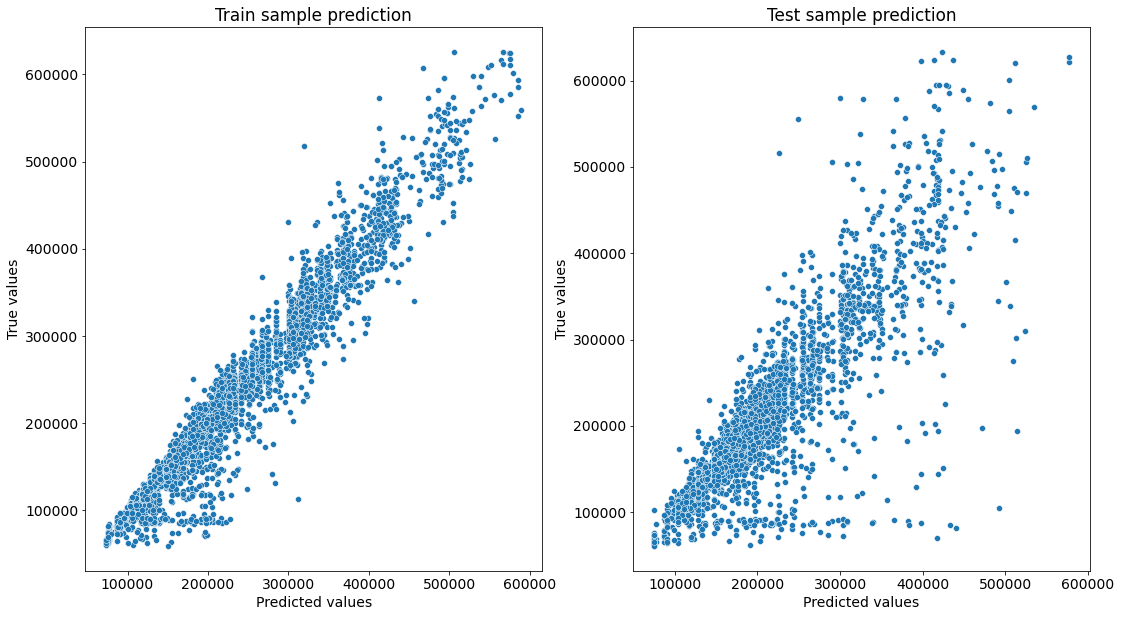

In [36]:
y_train_preds = stack.predict(X_train_scaled)
y_test_preds = stack.predict(X_valid_scaled)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Прогнозирование на тестовом датасете

In [37]:
test_df.shape

(5000, 24)

In [38]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,Ecology_1_zero,IsDistrictLarge,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,1,0,0,0,0,65.0,0,0,188753.163021
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,0,146.0,0,1,175233.891957
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1,1,0,0,0,1,563.0,0,1,176123.901215
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,1,0,0,0,0,373.0,0,1,179361.240076
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,6,1,0,0,0,1,72.0,0,0,190571.926428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,4,5.0,1962,0.069660,1,1,...,2,1,0,1,0,0,62.0,0,0,188753.163021
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,7,1,0,0,0,0,22.0,0,0,210416.979672
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,5,1,0,0,0,0,67.0,0,0,179361.240076
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,11,1,0,0,0,0,40.0,0,0,190571.926428


#### Загружаем формат предсказания для записи на Kagle

In [39]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


#### Выполняем расчет предсказанных величин согласно модели

In [40]:
predictions = stack.predict(test_df)
predictions

array([162441.94451947, 121619.9594162 , 150630.97422272, ...,
       147160.91515716, 190981.29930894, 254360.58929016])

#### Создаеам датасет в форме необходимой для подачи результатов на Kaggle

In [41]:
submit['Price'] = predictions
submit

,Id,Price
0,4567,162441.944519
1,5925,121619.959416
2,960,150630.974223
3,3848,131818.697292
4,746,212417.180696
...,...,...
4995,10379,190682.183394
4996,16138,362482.732160
4997,3912,147160.915157
4998,5722,190981.299309


#### Сохраняем результаты предсказания модели для загрузки на Kaggle

In [42]:
submit.to_csv('rf_submit.csv', index=False)

К сожалению на более детальную проработку нехватило времени.
На кагл подал результаты под ником **Vlad Feldchun**